# Distribution Free Direct Intervals 

### This notebook is written with the help of following repository:
### https://github.com/TeaPearce/Deep_Learning_Prediction_Intervals

### We have changed the code to PyTorch. Also, changed the cost function.

### Source of data
### https://www.kaggle.com/code/dipuk0506/toy-dataset-for-regression-and-uq

## References:
[Code Concept] Pearce, T., Brintrup, A., Zaki, M., & Neely, A. (2018, July). High-quality prediction intervals for deep learning: A distribution-free, ensembled approach. In International conference on machine learning (pp. 4075-4084). PMLR.

[Cost Function] Kabir, H. D., Khosravi, A., Kavousi-Fard, A., Nahavandi, S., & Srinivasan, D. (2021). Optimal uncertainty-guided neural network training. Applied Soft Computing, 99, 106878.

[Data Set] Kabir, H. M. D., Abdar, M., Khosravi, A., Nahavandi, D., Mohamed, S., Srinivasan, D., ... & Suganthan, P. N. (2021). Synthetic Datasets for Numeric Uncertainty Quantification.

[Pre-Train with Margin] Kabir, HM Dipu, et al. "Neural network training for uncertainty quantification over time-range." IEEE Transactions on Emerging Topics in Computational Intelligence 5.5 (2020): 768-779.


## 0. Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

## Considerations

In [2]:
# Training
EPOCH_initial = 1000
EPOCH = 5000
Error_th = 1e-3
Margin =0.25

# NN
hidden =1000

# hyperparameters of cost function
alpha_ = 0.05  # capturing (1-alpha)% of samples
delta_ = alpha_/50 # delts in loss fn
beta_1 = 1000 # PICP mismatch penalty
beta_2 = 200 # Bound swap penalty
rho_ = 1 # weight on PINAFD

## 1. Data

In [3]:
train_csv_path = '../input/toy-dataset-for-regression-and-uq/Data1_Train.csv'
test_csv_path = '../input/toy-dataset-for-regression-and-uq/Data1_Test.csv'
val_csv_path = '../input/toy-dataset-for-regression-and-uq/Data1_Val.csv'

train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
train_df.head()

,Input1,Output
0,0.000000,0.037112
1,0.001257,0.005684
2,0.002513,-0.017941
3,0.003770,0.020993
4,0.005027,-0.016084


In [4]:
input_=[]
output_=[]
for row in train_df.iloc:
    input_.append((row[0:len(row)-1]).astype(float))
    output_.append(row[-1])
    
i_val=[]
o_val=[]
for row in val_df.iloc:
    i_val.append((row[0:len(row)-1]).astype(float))
    o_val.append(row[-1])
    
num_input = len(row)-1;
print("Input Parameters", num_input)


Input Parameters 1


In [5]:
x = torch.tensor(input_).float()  
y = torch.tensor(output_).float()   
new_shape = (len(y), 1)
y = y.view(new_shape)

i_val = torch.tensor(i_val).float()  
o_val = torch.tensor(o_val).float()   
new_shape = (len(o_val), 1)
o_val = o_val.view(new_shape)

max_y = torch.max(y[:,0])
min_y =torch.min(y[:,0])

max_x = torch.max(x,dim=0)
min_x = torch.min(x,dim=0)

print(max_y, min_y, max_x.values, min_x.values)

range_y = max_y - min_y
range_x = max_x.values - min_x.values

print(range_x, range_y)

    #Normalizing
x = (x - min_x.values)/range_x
y = (y - min_y)/range_y

    #Normalizing
i_val = (i_val - min_x.values)/range_x
o_val = (o_val - min_y)/range_y

# create some data

X_train = x
y_train = y

tensor(1.0487) tensor(-1.0480) tensor([6.2819]) tensor([0.])
tensor([6.2819]) tensor(2.0967)


In [6]:
# define loss fn
def loss_objective(prediction, y):
    '''Loss Optimal LUBE'''
    y_u = prediction[:,0]
    y_l = prediction[:,1]
    length = len(y)
    
    pinaw = torch.mean(torch.abs(y_u-y_l))
    pinafd = torch.zeros(1)
    bsp = 0 # Bound Swap Penalty
    
    coverage_count = 0
    
    for iter1 in range(length):
        c = 0
        if y_u[iter1] < y_l[iter1]:
            bsp = bsp + torch.abs(y_l[iter1] - y_u[iter1])
        if y_u[iter1] >= y[iter1] and y_l[iter1] < y[iter1]:
            c = 1
            coverage_count = coverage_count + 1
        if c == 0:
            pinafd = pinafd + torch.min(torch.abs(y_u[iter1] - y[iter1]), torch.abs(y_l[iter1] - y[iter1]))
            # Minimum of difference becomes the failure distance
            
    pinafd = pinafd/(length - coverage_count + 1e-10)
    # 1e-10 is for avoiding the divided by zero error for 100% coverage
    picp = coverage_count/length
            
   
    Loss_S = pinaw + rho_*pinafd + beta_1*np.square(1-alpha_+delta_-picp) + beta_2*bsp
    
    return Loss_S

In [7]:
class Net_2l(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net_2l, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

# use the same net as before      
net = Net_2l(n_feature=num_input, n_hidden=hidden, n_output=2)     # define the network
print(net)  # net architecture

Net_2l(
  (hidden): Linear(in_features=1, out_features=1000, bias=True)
  (hidden2): Linear(in_features=1000, out_features=1000, bias=True)
  (predict): Linear(in_features=1000, out_features=2, bias=True)
)


### Initial training

In [8]:
y_target = torch.zeros(len(y),2)
y_target[:,0] = y[:,0] + Margin
y_target[:,1] = y[:,0] - Margin

y_t_val = torch.zeros(len(o_val),2)
y_t_val[:,0] = o_val[:,0] + Margin
y_t_val[:,1] = o_val[:,0] - Margin


optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

minimum_train_loss = 1e5 #High initial values
minimum_val_loss = 1e5


# start training
for epoch in range(EPOCH_initial):
  
    prediction = net(x)     # input x and predict based on x
    #print(prediction.shape, y.shape)

    loss = loss_func(prediction,y_target)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if loss<minimum_train_loss:
        minimum_train_loss =loss
        net_opt_train = net
    
    if epoch%100 == 99:
        prediction = net_opt_train(i_val)
        loss_val = loss_func(prediction, y_t_val)
        if loss_val<minimum_val_loss:
            minimum_val_loss = loss_val
            net_opt_val = net_opt_train
        
        print ("Epoch [{}/{}], "  .format(epoch+1, EPOCH))
        print("Loss:",loss.data.numpy().round(4), "Minimum Loss:",minimum_train_loss.data.numpy().round(6),"Val Loss:",minimum_val_loss.data.numpy().round(6))
        if minimum_val_loss.data.numpy() < Error_th:
            break
        
net = net_opt_val        
print("After Initial Training:  Loss:",loss.data.numpy().round(4), "Minimum Loss:",minimum_train_loss.data.numpy().round(6),"Val Loss:",minimum_val_loss.data.numpy().round(6))

Epoch [100/5000], 
Loss: 0.0391 Minimum Loss: 0.039148 Val Loss: 0.039128
Epoch [200/5000], 
Loss: 0.0226 Minimum Loss: 0.015838 Val Loss: 0.028629
Epoch [300/5000], 
Loss: 0.0128 Minimum Loss: 0.012774 Val Loss: 0.012711
Epoch [400/5000], 
Loss: 0.0205 Minimum Loss: 0.011308 Val Loss: 0.012711
Epoch [500/5000], 
Loss: 0.0093 Minimum Loss: 0.009297 Val Loss: 0.009251
Epoch [600/5000], 
Loss: 0.0125 Minimum Loss: 0.008093 Val Loss: 0.009251
Epoch [700/5000], 
Loss: 0.0062 Minimum Loss: 0.006245 Val Loss: 0.00621
Epoch [800/5000], 
Loss: 0.0051 Minimum Loss: 0.005085 Val Loss: 0.005289
Epoch [900/5000], 
Loss: 0.0039 Minimum Loss: 0.003883 Val Loss: 0.003856
Epoch [1000/5000], 
Loss: 0.0031 Minimum Loss: 0.003025 Val Loss: 0.003052
After Initial Training:  Loss: 0.0031 Minimum Loss: 0.003025 Val Loss: 0.003052


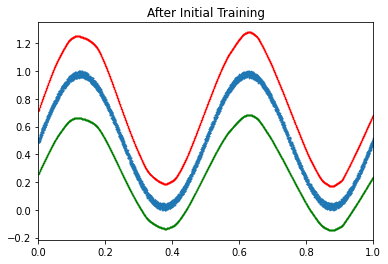

In [9]:
# plot and view some predictions
y_pred = net_opt_val(x).detach().numpy()
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(x[:,0],y[:,0], s=0.5)
plt.scatter(x[:,0], y_u_pred, color='r', s=0.05) # upper boundary prediction
plt.scatter(x[:,0], y_l_pred, color='g', s=0.05) # lower boundary prediction
plt.title('After Initial Training')
plt.xlim(0,1)
plt.show()

In [10]:
loss_func = loss_objective
optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)

prediction = net_opt_val(x)
minimum_train_loss = loss_func(prediction,y) 
prediction = net_opt_val(i_val)
minimum_val_loss = loss_func(prediction,o_val) 

print("In new cost: Training Loss:",minimum_train_loss.data.numpy().round(6),"Val Loss:",minimum_val_loss.data.numpy().round(6))

# start training
for epoch in range(EPOCH):
  
    prediction = net(x)     # input x and predict based on x
    #print(prediction.shape, y.shape)

    loss = loss_func(prediction,y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if loss<minimum_train_loss:
        minimum_train_loss =loss
        net_opt_train = net
    
    if epoch%100 == 99:
        prediction = net_opt_train(i_val)
        loss_val = loss_func(prediction, o_val)
        if loss_val<minimum_val_loss:
            minimum_val_loss = loss_val
            net_opt_val = net_opt_train 
            
        if loss_val>minimum_val_loss:    # Returning to previous validation best
            net = net_opt_val
            minimum_train_loss = loss_func(net_opt_val(x),y) 
        
        print ("Epoch [{}/{}], "  .format(epoch+1, EPOCH))
        print("Loss:",loss.data.numpy().round(4), "Minimum Loss:",minimum_train_loss.data.numpy().round(6),"Val Loss:",minimum_val_loss.data.numpy().round(6))

In new cost: Training Loss: [2.857584] Val Loss: [2.857584]
Epoch [100/5000], 
Loss: [2.7924] Minimum Loss: [2.750926] Val Loss: [2.791977]
Epoch [200/5000], 
Loss: [2.7599] Minimum Loss: [2.701898] Val Loss: [2.759587]
Epoch [300/5000], 
Loss: [2.7076] Minimum Loss: [2.669044] Val Loss: [2.726721]
Epoch [400/5000], 
Loss: [2.6938] Minimum Loss: [2.63522] Val Loss: [2.693476]
Epoch [500/5000], 
Loss: [2.6608] Minimum Loss: [2.622246] Val Loss: [2.660456]
Epoch [600/5000], 
Loss: [2.627] Minimum Loss: [2.610404] Val Loss: [2.626666]
Epoch [700/5000], 
Loss: [2.5906] Minimum Loss: [2.549292] Val Loss: [2.590205]
Epoch [800/5000], 
Loss: [2.5505] Minimum Loss: [2.543497] Val Loss: [2.550091]
Epoch [900/5000], 
Loss: [2.5066] Minimum Loss: [2.489157] Val Loss: [2.506176]
Epoch [1000/5000], 
Loss: [1.8037] Minimum Loss: [1.803744] Val Loss: [1.896135]
Epoch [1100/5000], 
Loss: [3.0806] Minimum Loss: [3.21341] Val Loss: [1.896135]
Epoch [1200/5000], 
Loss: [62.7653] Minimum Loss: [63.56901] 

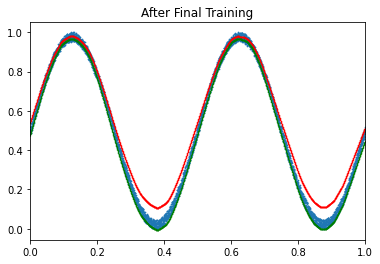

In [11]:
# plot and view some predictions
y_pred = net_opt_val(x).detach().numpy()
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(x[:,0],y[:,0], s=0.5)
plt.scatter(x[:,0], y_u_pred, color='r', s=0.05) # upper boundary prediction
plt.scatter(x[:,0], y_l_pred, color='g', s=0.05) # lower boundary prediction
plt.title('After Final Training')
plt.xlim(0,1)
plt.show()